<a href="https://colab.research.google.com/github/nurastars/tugas_dicoding/blob/main/tugas_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install split-folders

In [2]:
import os
import zipfile
from zipfile import ZipFile
import pandas as pd
import numpy as np
import splitfolders
import matplotlib.pyplot as plt
import PIL
import shutil
from PIL import Image, ImageOps
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from google.colab import files
from tensorflow.keras.preprocessing import image
from google.colab import files
from tensorflow.keras.models import Sequential
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D,Activation,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report

In [3]:
with ZipFile('/content/fruitss1.ZIP', 'r') as dataset:
  dataset.extractall('/content/datasetku')

In [4]:

target = ['Tomato',  'buah_Apple', 'buah_cherry']


dataset_dir = '/content/datasetku/'

In [5]:
splitfolders.ratio(dataset_dir, output = '/content/split_dataset',
                   seed = 45, ratio = (0.8, 0.2))

train_dir = '/content/split_dataset/train/'
val_dir = '/content/split_dataset/val/'

Copying files: 8885 files [00:01, 4539.04 files/s]


Jumlah Tomato: 5603
Jumlah buah_Apple: 2134
Jumlah buah_cherry: 1148
Total Image: 8885


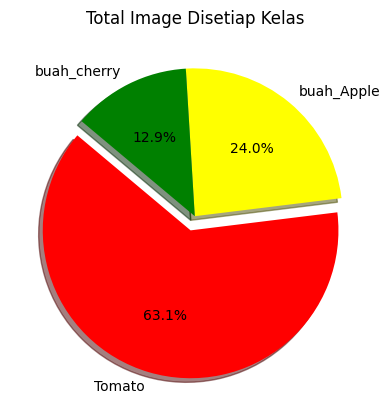

In [6]:
jumlah_image = []

for kelas in range(len(target)):
  kelas_train = len(os.listdir(train_dir + target[kelas]))
  kelas_val = len(os.listdir(val_dir + target[kelas]))
  jumlah_image.append(kelas_train + kelas_val)
  print("Jumlah {}: {}".format(target[kelas],
                               jumlah_image[kelas]))

print("Total Image:", np.array(jumlah_image).sum())

plt.pie(jumlah_image, explode=[0.1, 0, 0], labels= target, colors=['red', 'yellow', 'green']
, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Total Image Disetiap Kelas')
plt.show()

In [7]:

train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 20,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [.7, 1.3],
    width_shift_range = 0.3,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(
    rescale = 1.0/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 8,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 8,
    class_mode = 'categorical'
)



Found 7107 images belonging to 3 classes.
Found 1778 images belonging to 3 classes.


In [17]:

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=3, activation='softmax')) #

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nTarget Akurasi Sudah diperoleh, maka stooop saja!.")
            self.model.stop_training = True


my_callback = MyCallback()

rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [18]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

CALLBACKS = [my_callback, rop_callback]

model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 41472)             0         
                                                                 
 dense_6 (Dense)             (None, 512)              

In [19]:
EPOCHS = 100
history= model.fit(train_generator,
                   batch_size=16,
                   verbose=True,
                   validation_data= val_generator,
                   callbacks=CALLBACKS,
                   epochs=EPOCHS)

Epoch 1/100
889/889 [==============================] - 552s 619ms/step - loss: 0.4392 - acc: 0.8613 - auc: 0.9664 - val_loss: 0.1041 - val_acc: 0.9550 - val_auc: 0.9958 - lr: 0.0010
Epoch 2/100
889/889 [==============================] - 542s 609ms/step - loss: 0.1344 - acc: 0.9561 - auc: 0.9931 - val_loss: 0.0098 - val_acc: 0.9966 - val_auc: 1.0000 - lr: 0.0010
Epoch 3/100
889/889 [==============================] - 529s 595ms/step - loss: 0.1064 - acc: 0.9776 - auc: 0.9957 - val_loss: 0.0120 - val_acc: 0.9944 - val_auc: 1.0000 - lr: 0.0010
Epoch 4/100
889/889 [==============================] - 553s 622ms/step - loss: 0.0651 - acc: 0.9852 - auc: 0.9972 - val_loss: 0.0040 - val_acc: 0.9989 - val_auc: 1.0000 - lr: 0.0010
Epoch 5/100
889/889 [==============================] - ETA: 0s - loss: 0.0457 - acc: 0.9916 - auc: 0.9978
Target Akurasi Sudah diperoleh, maka stooop saja!.
889/889 [==============================] - 541s 609ms/step - loss: 0.0457 - acc: 0.9916 - auc: 0.9978 - val_loss: 1

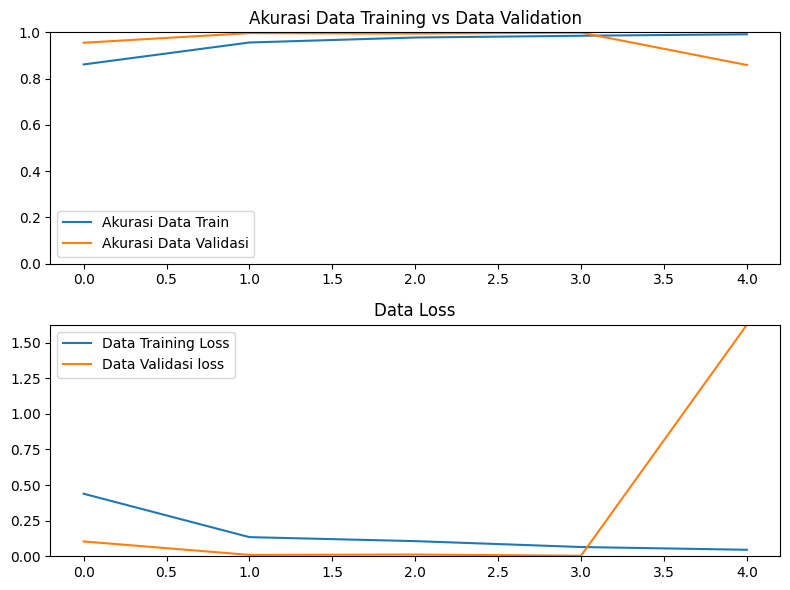

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))

get_accuracy = history.history['acc']
value_accuracy = history.history['val_acc']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

ax[0].plot(get_accuracy, label = 'Akurasi Data Train')
ax[0].plot(value_accuracy, label = 'Akurasi Data Validasi')
ax[1].plot(get_loss, label = 'Data Training Loss')
ax[1].plot(validation_loss, label = 'Data Validasi loss')

ax[0].legend()
ax[1].legend()

ax[0].set_ylim([0,1])
ax[1].set_ylim([0,max(get_loss +validation_loss)])

ax[0].set_title('Akurasi Data Training vs Data Validation')
ax[1].set_title('Data Loss')

fig.tight_layout()
plt.show()

Saving 4_100 (5).jpg to 4_100 (5).jpg
1/1 [==============================] - 0s 33ms/step
Gambar di bawah ini adalah APPLE


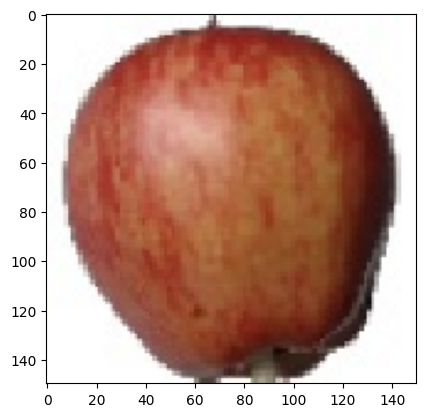

In [22]:
uploaded = files.upload()

for Gambar in uploaded.keys():

  img = image.load_img(Gambar, target_size=(150, 150))

  imgplot = plt.imshow(img)

  # convert Gambar to array
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  # Menebak Gambar
  prediksi = model.predict(images, batch_size= 10)

  if np.where(prediksi[0] == 1)[0][0] == 0:
    print('Gambar di bawah ini adalah TOMATO')
  elif np.where(prediksi[0] == 1)[0][0] == 1:
    print('Gambar di bawah ini adalah APPLE')
  else:
    print('Gambar di bawah ini adalah cHERRY')

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

In [25]:
model.save("tflite_model.pb")